In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=7cf2ba3fa9222046308d4460c6722f637f9af26deb891cb2e4200135390f014b
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create a Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
#Read json file in spark
df = spark.read.json("/content/drive/MyDrive/Project_v2/data_1.jsonl")

In [ ]:
#Print the schema of the dataset
df.printSchema()

root
 |-- __twarc: struct (nullable = true)
 |    |-- retrieved_at: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachments: struct (nullable = true)
 |    |    |    |-- media_keys: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- poll_ids: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- context_annotations: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- domain: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- entity: str

In [ ]:
#Print the count of the total dataset
#This code might take several minutes to run
df.count()

5746

In [ ]:
#display dataframe
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|             __twarc|                data|              errors|            includes|                meta|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{2022-11-16T20:27...|[{null, 235933769...|[{User has been s...|{[{null, null, 50...|{1488301063363084...|
|{2022-11-16T20:27...|[{null, 253536714...|[{Sorry, you are ...|{[{null, null, 47...|{1488299308558417...|
|{2022-11-16T20:27...|[{null, 862197469...|[{Sorry, you are ...|{[{null, null, 12...|{1488297267056594...|
|{2022-11-16T20:27...|[{null, 130130632...|[{Sorry, you are ...|{[{null, 37291, 9...|{1488295319624429...|
|{2022-11-16T20:27...|[{null, 103491630...|[{Sorry, you are ...|{[{null, null, 12...|{1488293401367748...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#Print the column names of the dataset
df.columns

['__twarc', 'data', 'errors', 'includes', 'meta']

As we do not need all the fields that we have in the dataset, in the next few steps we will break the orginal data into two dataframes with fields that we need

In [ ]:
#This is the first dataframe and following it is the schema of the dataset
df_1 = df.select("includes.tweets.author_id", "includes.tweets.conversation_id", "includes.tweets.created_at", "includes.tweets.entities.hashtags", "includes.tweets.entities.mentions", "includes.tweets.id", "includes.tweets.in_reply_to_user_id", "includes.tweets.lang", "includes.tweets.possibly_sensitive", "includes.tweets.public_metrics.like_count", "includes.tweets.public_metrics.quote_count", "includes.tweets.public_metrics.reply_count","includes.tweets.public_metrics.retweet_count","includes.tweets.referenced_tweets", "includes.tweets.text")
df_1.printSchema()

root
 |-- author_id: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- conversation_id: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- created_at: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- end: long (nullable = true)
 |    |    |    |-- start: long (nullable = true)
 |    |    |    |-- tag: string (nullable = true)
 |-- mentions: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- end: long (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- start: long (nullable = true)
 |    |    |    |-- username: string (nullable = true)
 |-- id: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- in_reply_t

While converting API Json data to dataframe, it results in lists of lists as the entity of the dataframe. This needs to be exploded so that each row has a single element and not an array element. So, the following steps show how we exploded it into multiple columns. 

In [ ]:
#Exploding multiple columns at the same time
from pyspark.sql.functions import arrays_zip, explode

df_final = df_1.select("conversation_id",explode(arrays_zip("author_id", "created_at", "hashtags", "mentions","id","in_reply_to_user_id","lang", "possibly_sensitive", "like_count", "quote_count", "reply_count", "retweet_count", "referenced_tweets", "text")))
df_final.show()

+--------------------+--------------------+
|     conversation_id|                 col|
+--------------------+--------------------+
|[1488301063363084...|{2359337692, 2022...|
|[1488301063363084...|{1378022598752223...|
|[1488301063363084...|{627019754, 2022-...|
|[1488301063363084...|{216776631, 2022-...|
|[1488301063363084...|{494287469, 2022-...|
|[1488301063363084...|{2155641480, 2022...|
|[1488301063363084...|{939296060, 2022-...|
|[1488301063363084...|{752952668, 2022-...|
|[1488301063363084...|{67358777, 2022-0...|
|[1488301063363084...|{8407332989890969...|
|[1488301063363084...|{1201902968355905...|
|[1488301063363084...|{1428498179369193...|
|[1488301063363084...|{1352735428726632...|
|[1488301063363084...|{13340732, 2022-0...|
|[1488301063363084...|{7373708034113904...|
|[1488301063363084...|{358530210, 2022-...|
|[1488301063363084...|{192944972, 2022-...|
|[1488301063363084...|{8373319925806202...|
|[1488301063363084...|{2181308226, 2022...|
|[1488301063363084...|{327053266

In [ ]:
#Unzipping the elements from "col" column to seperate columns
df_final_2 = df_final.select("conversation_id","col.author_id","col.created_at","col.hashtags","col.mentions","col.id","col.in_reply_to_user_id", "col.lang", "col.possibly_sensitive", "col.like_count", "col.quote_count", "col.reply_count", "col.retweet_count", "col.referenced_tweets", "col.text")
df_final_2.show()

+--------------------+-------------------+--------------------+--------+--------------------+-------------------+-------------------+----+------------------+----------+-----------+-----------+-------------+--------------------+--------------------+
|     conversation_id|          author_id|          created_at|hashtags|            mentions|                 id|in_reply_to_user_id|lang|possibly_sensitive|like_count|quote_count|reply_count|retweet_count|   referenced_tweets|                text|
+--------------------+-------------------+--------------------+--------+--------------------+-------------------+-------------------+----+------------------+----------+-----------+-----------+-------------+--------------------+--------------------+
|[1488301063363084...|         2359337692|2022-01-31T23:59:...|    null|[{18, 13780225987...|1488301063363084290|               null|  en|             false|         0|          0|          0|           31|[{148827187854457...|RT @Kat4District1...|
|[14

In [ ]:
#Number of rows of first dataframe after exploding
#This line might take a longer time to execute, so if not required skip this part
df_final_2.count()

In [ ]:
df_final_2 = df_final_2.drop("conversation_id", "hashtags", "mentions", "referenced_tweets")

In [ ]:
df_final_2.show()

+-------------------+--------------------+-------------------+-------------------+----+------------------+----------+-----------+-----------+-------------+--------------------+
|          author_id|          created_at|                 id|in_reply_to_user_id|lang|possibly_sensitive|like_count|quote_count|reply_count|retweet_count|                text|
+-------------------+--------------------+-------------------+-------------------+----+------------------+----------+-----------+-----------+-------------+--------------------+
|         2359337692|2022-01-31T23:59:...|1488301063363084290|               null|  en|             false|         0|          0|          0|           31|RT @Kat4District1...|
|1378022598752223235|2022-01-31T22:04:...|1488271878544576514|               null|  en|             false|        85|          0|          3|           31|I am deeply honor...|
|          627019754|2022-01-31T23:59:...|1488301058891948033|               null|  en|             false|         

In [ ]:
#uncomment this line if any changes have been made to the dataframe so that it reflects in the csv file
#df_final_2.write.format("csv").mode('overwrite').save("/content/drive/MyDrive/Project_v2/tweets.csv")

Similar steps for the second dataframe

In [ ]:
#Select fields for second dataframe from the main dataframe and print its schema
df_2 = df.select("includes.users.created_at","includes.users.description", "includes.users.id", "includes.users.location", "includes.users.name", "includes.users.protected", "includes.users.public_metrics.followers_count", "includes.users.public_metrics.following_count","includes.users.public_metrics.listed_count","includes.users.public_metrics.tweet_count","includes.users.username", "includes.users.verified")
df_2.printSchema()

root
 |-- created_at: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- location: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- protected: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- followers_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- following_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- listed_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- tweet_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- username: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- verified: array (nullab

In [ ]:
#Print the table structure of the second dataframe
df_2.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          created_at|         description|                  id|            location|                name|           protected|     followers_count|     following_count|        listed_count|         tweet_count|            username|            verified|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|[2014-02-22T20:33...|[I retired in 200...|[2359337692, 1378...|[Florida, USA, Wi...|[💙💙💛💛Fred 💛?...|[false, false, fa...|[17664, 32456, 97...|[17949, 8074, 392...|[9, 69, 0, 23875,...|[153206, 1647, 37...|[fcretired, Kat4D...|[false, tru

In [ ]:
#Exploding the json data so that each row has a single element and not an array element
new_df = df_2.select("created_at",explode(arrays_zip("description", "id", "location", "name", "protected","followers_count","following_count","listed_count", "tweet_count", "username", "verified")))
new_df.show()

+--------------------+--------------------+
|          created_at|                 col|
+--------------------+--------------------+
|[2014-02-22T20:33...|{I retired in 200...|
|[2014-02-22T20:33...|{Kathleen for Con...|
|[2014-02-22T20:33...|{You are worthy a...|
|[2014-02-22T20:33...|{U.S. Senator for...|
|[2014-02-22T20:33...|{finalist for the...|
|[2014-02-22T20:33...|{I write about po...|
|[2014-02-22T20:33...|{ex nihilo nihil ...|
|[2014-02-22T20:33...|{Oil and Gas advi...|
|[2014-02-22T20:33...|{Covering the bus...|
|[2014-02-22T20:33...|{A Christo-fascis...|
|[2014-02-22T20:33...|{Paid Leave for A...|
|[2014-02-22T20:33...|{, 14284981793691...|
|[2014-02-22T20:33...|{Distributor of t...|
|[2014-02-22T20:33...|{Nurse, who wante...|
|[2014-02-22T20:33...|{Author Traveller...|
|[2014-02-22T20:33...|{I'm me, 73737080...|
|[2014-02-22T20:33...|{Don’t ever go wi...|
|[2014-02-22T20:33...|{He who bow befor...|
|[2014-02-22T20:33...|{African / Igbo \...|
|[2014-02-22T20:33...|{Plant a t

In [ ]:
#Unzipping elements from "col" column to seperate columns
new_df_2 = new_df.select("col.description","col.id","col.location","col.name","col.protected","col.followers_count","col.following_count", "col.listed_count", "col.tweet_count", "col.username", "col.verified")
new_df_2.show()

+--------------------+-------------------+--------------------+--------------------+---------+---------------+---------------+------------+-----------+---------------+--------+
|         description|                 id|            location|                name|protected|followers_count|following_count|listed_count|tweet_count|       username|verified|
+--------------------+-------------------+--------------------+--------------------+---------+---------------+---------------+------------+-----------+---------------+--------+
|I retired in 2001...|         2359337692|        Florida, USA|💙💙💛💛Fred 💛💛...|    false|          17664|          17949|           9|     153206|      fcretired|   false|
|Kathleen for Cong...|1378022598752223235|   Wichita Falls, TX|      Kathleen Brown|    false|          32456|           8074|          69|       1647| Kat4District13|    true|
|You are worthy at...|          627019754|             Georgia|        thasighray🌬|    false|             97|            

In [ ]:
#uncomment this line if changes have been made to the dataframe above so that the change reflects in csv file
#new_df_2.write.format("csv").mode('overwrite').save("/content/drive/MyDrive/Project_v2/users.csv")

In [ ]:
#Number of rows of second dataframe after exploding
#This might take several minutes to run. So skip this part if not required
new_df_2.count()

899270

**Exploring Location Data**

In [ ]:
df_location = new_df_2.select("location")

In [ ]:
df_dis_location = df_location.distinct()

In [ ]:
#Count of distinct number of locations present in the dataset
df_dis_location.count()

120827

In [ ]:
df_dis_location.show(100)

+--------------------+
|            location|
+--------------------+
|            Novi, MI|
|     Gainesville, FL|
|                Utah|
|              Heaven|
|Ferrara, Emilia R...|
|Oakland ⬅ Denver ...|
|   Ally's World 🥰❤️|
|   St Petersburg, FL|
|Louisville, Louis...|
|           Bangalore|
|FIXIN TO SHAVE MI...|
|Magistri Neque Servi|
|USA Canada Mexico...|
|       Jonesboro, AR|
|        here and now|
|  Caracas, Venezuela|
|        Far Far Away|
| Brisbane, Australia|
|              online|
|Kalifornia, Texas...|
|      St. Louis, Mo.|
|🏴󠁧󠁢󠁷󠁬󠁳󠁿 he...|
|      Luton, England|
|Brisbane, Australia |
|            The City|
| Westminster, London|
|    South Africa,PTA|
|Covent Garden, Lo...|
|              iCloud|
|            England |
|   Nairobi.....Kenya|
|         Brooklyn NY|
|     Manilva, España|
|                 CA |
|        Naples,Italy|
|  Seattle Washington|
|Nuwuvi Land (Las ...|
| Mumbai, Maharashtra|
|          Dreamland |
|    SRQ Florida, USA|
|           Socials

**Exploring Language Data**

In [ ]:
df_language = df_final_2.select("lang")

In [ ]:
#count of distinct number of languages present in the dataset
df_language.distinct().count()

60

In [ ]:
df_distinct_language = df_language.distinct()

In [ ]:
#df_distinct_language.show()

**Exploring Verified Users Data**

In [ ]:
df_verified = new_df_2.select("verified")

In [ ]:
df_verified.select('verified').where(df_verified.verified == True).count()

138859

In [ ]:
df_verified.select("verified").where(df_verified.verified == False).count()

760411

In [ ]:
#The percentage of total verified users in the total dataset is
(138859/(138859+760411))*100

15.441302389716101

In [ ]:
#The percentage of total non verified users in the total dataset is
(760411/(138859+760411))*100

84.5586976102839

**Exploring Engagement Factors in Gender Wage Gap data**

In [ ]:
df_engage = df_final_2.select("like_count", "quote_count", "retweet_count", "reply_count")

In [ ]:
df_engage.select("like_count").describe().show()

+-------+------------------+
|summary|        like_count|
+-------+------------------+
|  count|            771220|
|   mean|1462.7485672052073|
| stddev|12476.053034570174|
|    min|                 0|
|    max|           2509939|
+-------+------------------+



In [ ]:
df_engage.select("quote_count").describe().show()

+-------+------------------+
|summary|       quote_count|
+-------+------------------+
|  count|            771220|
|   mean| 35.62526516428516|
| stddev|494.43722642444953|
|    min|                 0|
|    max|             87604|
+-------+------------------+



In [ ]:
df_engage.select("retweet_count").describe().show()

+-------+------------------+
|summary|     retweet_count|
+-------+------------------+
|  count|            771220|
|   mean|3553.7429112315554|
| stddev| 8406.863515476012|
|    min|                 0|
|    max|            981148|
+-------+------------------+



In [ ]:
df_engage.select("reply_count").describe().show()

+-------+-----------------+
|summary|      reply_count|
+-------+-----------------+
|  count|           771220|
|   mean|62.52213376209123|
| stddev|3458.075513920934|
|    min|                0|
|    max|          1535726|
+-------+-----------------+



**How are people interacting with tweets from Verified and non Verified Users**

Supposing that people interact with tweets in the form of likes, replies, comments and quotes, we perform hypothesis testing with these metrics.

First of all, we prepare a dataframe with required information and in the next few steps, we perform hypothesis testing. 

In [ ]:
#select columns to retrieve
df_hyp = df.select("includes.tweets.author_id",  "includes.tweets.lang", "includes.tweets.public_metrics.like_count", "includes.tweets.public_metrics.quote_count", "includes.tweets.public_metrics.reply_count","includes.tweets.public_metrics.retweet_count", "includes.users.verified")
df_hyp.printSchema()

root
 |-- author_id: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lang: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- like_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- quote_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- reply_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- retweet_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- verified: array (nullable = true)
 |    |-- element: boolean (containsNull = true)



In [ ]:
#Explode json data so that each row has an individual element and not a dictionary
new_df_hyp = df_hyp.select("author_id",explode(arrays_zip("lang", "like_count", "quote_count", "reply_count", "retweet_count","verified")))
new_df_hyp.show()

+--------------------+--------------------+
|           author_id|                 col|
+--------------------+--------------------+
|[2359337692, 1378...|{en, 0, 0, 0, 31,...|
|[2359337692, 1378...|{en, 85, 0, 3, 31...|
|[2359337692, 1378...|{en, 0, 0, 0, 183...|
|[2359337692, 1378...|{en, 9745, 133, 6...|
|[2359337692, 1378...|{en, 0, 0, 0, 69,...|
|[2359337692, 1378...|{en, 442, 7, 5, 6...|
|[2359337692, 1378...|{en, 2, 0, 1, 1, ...|
|[2359337692, 1378...|{en, 9, 4, 1, 4, ...|
|[2359337692, 1378...|{en, 2, 0, 0, 0, ...|
|[2359337692, 1378...|{en, 0, 0, 0, 34,...|
|[2359337692, 1378...|{en, 126, 2, 4, 3...|
|[2359337692, 1378...|{en, 0, 0, 0, 0, ...|
|[2359337692, 1378...|{en, 0, 0, 0, 0, ...|
|[2359337692, 1378...|{en, 28160, 296, ...|
|[2359337692, 1378...|{en, 0, 0, 0, 183...|
|[2359337692, 1378...|{en, 0, 0, 0, 183...|
|[2359337692, 1378...|{en, 0, 0, 0, 359...|
|[2359337692, 1378...|{en, 1106, 14, 44...|
|[2359337692, 1378...|{en, 0, 0, 0, 183...|
|[2359337692, 1378...|{en, 0, 0,

In [ ]:
#Seperate the returned array to individual columns
new_df_hyp = new_df_hyp.select("col.lang","col.like_count","col.quote_count","col.reply_count","col.retweet_count","col.verified")
new_df_hyp.show()

+----+----------+-----------+-----------+-------------+--------+
|lang|like_count|quote_count|reply_count|retweet_count|verified|
+----+----------+-----------+-----------+-------------+--------+
|  en|         0|          0|          0|           31|   false|
|  en|        85|          0|          3|           31|    true|
|  en|         0|          0|          0|         1833|   false|
|  en|      9745|        133|        698|         1833|    true|
|  en|         0|          0|          0|           69|    true|
|  en|       442|          7|          5|           69|   false|
|  en|         2|          0|          1|            1|   false|
|  en|         9|          4|          1|            4|   false|
|  en|         2|          0|          0|            0|    true|
|  en|         0|          0|          0|           34|   false|
|  en|       126|          2|          4|           34|   false|
|  en|         0|          0|          0|            0|   false|
|  en|         0|        

In [ ]:
#summary statistics for verified and unverified users
new_df_hyp.groupBy("verified").count().show()

+--------+------+
|verified| count|
+--------+------+
|    null|  1735|
|    true|138859|
|   false|760411|
+--------+------+



In [ ]:
#make two different dataframes for verified and unverified users
new_df_hyp = new_df_hyp.na.drop()
df_verified_users = new_df_hyp.select('verified', 'like_count', 'quote_count', 'reply_count', 'retweet_count').where(new_df_hyp.verified == True)
df_non_verified_users = new_df_hyp.select('verified', 'like_count', 'quote_count', 'reply_count', 'retweet_count').where(new_df_hyp.verified == False)
df_verified_users.show()

+--------+----------+-----------+-----------+-------------+
|verified|like_count|quote_count|reply_count|retweet_count|
+--------+----------+-----------+-----------+-------------+
|    true|        85|          0|          3|           31|
|    true|      9745|        133|        698|         1833|
|    true|         0|          0|          0|           69|
|    true|         2|          0|          0|            0|
|    true|         0|          0|          0|         1833|
|    true|         0|          0|          0|          861|
|    true|       175|          1|          7|            1|
|    true|         0|          0|          0|            2|
|    true|         1|          0|          0|            0|
|    true|         0|          0|          0|         1833|
|    true|         0|          0|          0|          861|
|    true|         0|          0|          0|           39|
|    true|         0|          0|          0|            1|
|    true|         0|          0|       

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

In [ ]:
#conversion of Pyspark dataframe to Pandas Dataframe
verified_users = df_verified_users.toPandas()
non_verified_users = df_non_verified_users.toPandas()

In [ ]:
verified_users['like_count'] = verified_users['like_count'].astype('float')
non_verified_users['like_count'] = non_verified_users['like_count'].astype('float')

In [ ]:
#ttest results for like counts
ttest_ind(verified_users['like_count'], non_verified_users['like_count'])

Ttest_indResult(statistic=4.773788169222443, pvalue=1.8082568694643924e-06)

In [ ]:
#ttest results for quote counts
ttest_ind(verified_users['quote_count'], non_verified_users['quote_count'])

Ttest_indResult(statistic=4.847438133893213, pvalue=1.2509033213711203e-06)

In [ ]:
#ttest results for reply counts
ttest_ind(verified_users['reply_count'], non_verified_users['reply_count'])

Ttest_indResult(statistic=4.021610071799337, pvalue=5.780719370250295e-05)

In [ ]:
#ttest results for retweet counts
ttest_ind(verified_users['retweet_count'], non_verified_users['retweet_count'])

Ttest_indResult(statistic=-40.449238037429225, pvalue=0.0)

**Text Preprocessing and Analytics**

In [ ]:
#Retrieve columns with id, engagement factors and actual text from tweets
df_text = df_final_2.select("id","like_count","quote_count","reply_count","retweet_count", "text")

#display retrieved dataframe
df_text.show()

In [ ]:
from pyspark.sql.functions import udf, col, lower, regexp_replace

In [ ]:
#Remove Punctuation and Convert the text to lowercase
df_clean = df_text.select('id',"like_count","quote_count","reply_count","retweet_count", (lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')))

df_clean.show()

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

In [ ]:
#Tokenize text
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('id', 'like_count','quote_count','reply_count','retweet_count', 'words_token')

df_words_token.show()

In [ ]:
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('id','like_count','quote_count','reply_count','retweet_count', 'words_clean')

df_words_no_stopw.show()

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import StringType, ArrayType

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('id', 'like_count','quote_count','reply_count','retweet_count', 'words_stemmed')

df_stemmed.show()

In [ ]:
# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

df_final_words.show()

In [ ]:
#drop columns with NA values
df_dropped = df_final_words.na.drop()

#uncomment this line if count is required
#df_dropped.count()

#uncomment this line if count is required
#df_final_words.count()

In [ ]:
#drop columns with duplicates
df_distinct = df_dropped.distinct()

#uncomment this line if count is required
#df_distinct.count()

In [ ]:
#Write DataFrame to CSV file
#df_distinct.write.csv("/content/drive/MyDrive/Project_v2/text.csv")
#df_distinct.write.format("csv").mode('overwrite').save("/content/drive/MyDrive/Project_v2/text.csv")

In [ ]:
#This line takes 20 minutes to execute
words_distinct = df_distinct.toPandas()

In [ ]:
words_distinct.head()

,id,like_count,quote_count,reply_count,retweet_count,words_stemmed,words
0,1488300226586845191,0,0,0,1833,"[rt, berniesand, germani, guarante, peopl, , w...","[berniesand, germani, guarante, peopl, week, p..."
1,1488299397180194817,0,0,0,6,"[rt, mercyrx, danielhurstbn, everi, time, labo...","[mercyrx, danielhurstbn, everi, time, labor, p..."
2,1488289303528677379,3,0,1,0,"[jimmydc, berniesand, hes, talk, compani, hes,...","[jimmydc, berniesand, hes, talk, compani, hes,..."
3,1488283990662561800,2,0,0,0,"[thing, concert, pay, money, good, seat, video...","[thing, concert, pay, money, good, seat, video..."
4,1488279343444856832,2,0,1,0,"[ladydoctorsay, feel, like, pay, cap, deflatio...","[ladydoctorsay, feel, like, pay, cap, deflatio..."


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
words = words_distinct['words']
words

In [ ]:
for i in range(len(words)):
    words[i] = ' '.join(words[i])

<ipython-input-36-d3ece15ca76a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words[i] = ' '.join(words[i])


In [ ]:
words_distinct['new_words'] = words

In [ ]:
words = ' '.join([text for text in words_distinct['new_words']])

**Wordclouds from frequently used words in Gender Pay Gap tweets**

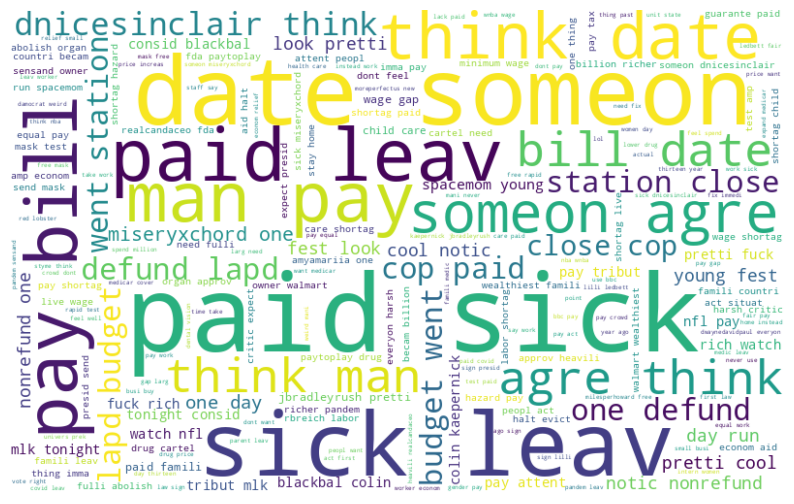

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, background_color = 'white', random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
from textblob import TextBlob

**Get Polarity Scores of Tweets using TextBlob Library**

In [ ]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
def getPolarity(text):
   return TextBlob(text).sentiment.polarity

  #Create two new columns ‘Subjectivity’ & ‘Polarity’
words_distinct["TextBlob_Subjectivity"] = words_distinct["words"].apply(getSubjectivity)
words_distinct["TextBlob_Polarity"] = words_distinct["words"].apply(getPolarity)

In [ ]:
words_distinct.columns

Index(['id', 'like_count', 'quote_count', 'reply_count', 'retweet_count',
       'words_stemmed', 'words', 'new_words', 'TextBlob_Subjectivity',
       'TextBlob_Polarity'],
      dtype='object')

**Label tweets to positive, negative and neutral on the basis of their polarity scores**

In [ ]:
def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"


words_distinct["TextBlob_Analysis"] = words_distinct["TextBlob_Polarity"].apply(getAnalysis )

In [ ]:
words_distinct

,id,like_count,quote_count,reply_count,retweet_count,words_stemmed,words,new_words,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,1488300226586845191,0,0,0,1833,"[rt, berniesand, germani, guarante, peopl, , w...",berniesand germani guarante peopl week paid si...,berniesand germani guarante peopl week paid si...,0.857143,-0.714286,Negative
1,1488299397180194817,0,0,0,6,"[rt, mercyrx, danielhurstbn, everi, time, labo...",mercyrx danielhurstbn everi time labor propos ...,mercyrx danielhurstbn everi time labor propos ...,0.000000,0.000000,Neutral
2,1488289303528677379,3,0,1,0,"[jimmydc, berniesand, hes, talk, compani, hes,...",jimmydc berniesand hes talk compani hes talk g...,jimmydc berniesand hes talk compani hes talk g...,0.857143,-0.714286,Negative
3,1488283990662561800,2,0,0,0,"[thing, concert, pay, money, good, seat, video...",thing concert pay money good seat video direct...,thing concert pay money good seat video direct...,0.600000,0.700000,Positive
4,1488279343444856832,2,0,1,0,"[ladydoctorsay, feel, like, pay, cap, deflatio...",ladydoctorsay feel like pay cap deflationari c...,ladydoctorsay feel like pay cap deflationari c...,0.304167,-0.145833,Negative
...,...,...,...,...,...,...,...,...,...,...,...
623550,1477103100854870016,0,0,0,19,"[rt, picardonhealth, medicin, gender, power, g...",picardonhealth medicin gender power gap set wo...,picardonhealth medicin gender power gap set wo...,0.066667,-0.166667,Negative
623551,1477093437409169410,2,0,1,0,"[thcuc, yes, realli, watch, , use, work, much,...",thcuc yes realli watch use work much overtim s...,thcuc yes realli watch use work much overtim s...,0.300000,0.500000,Positive
623552,1477079243733581825,0,0,0,194,"[rt, teneikaaskyou, aw, build, cloudup, train,...",teneikaaskyou build cloudup train amp certif p...,teneikaaskyou build cloudup train amp certif p...,0.800000,0.400000,Positive
623553,1477071610112839683,7,0,1,0,"[lofipriest, mom, work, switch, , day, year, p...",lofipriest mom work switch day year pay great ...,lofipriest mom work switch day year pay great ...,0.475000,0.500000,Positive


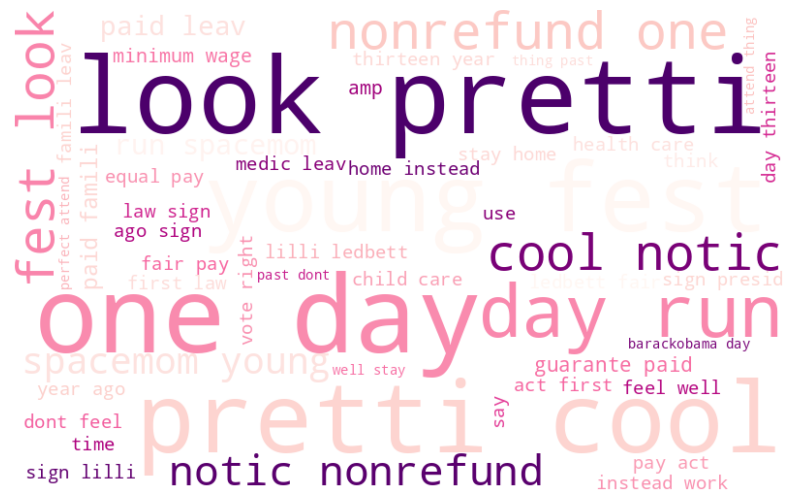

In [ ]:
#display wordcloud for positive words
positive_words =' '.join([text for text in words_distinct['new_words'][words_distinct['TextBlob_Analysis'] == "Positive"]])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color = 'white', colormap='RdPu', max_font_size=110, max_words = 50).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

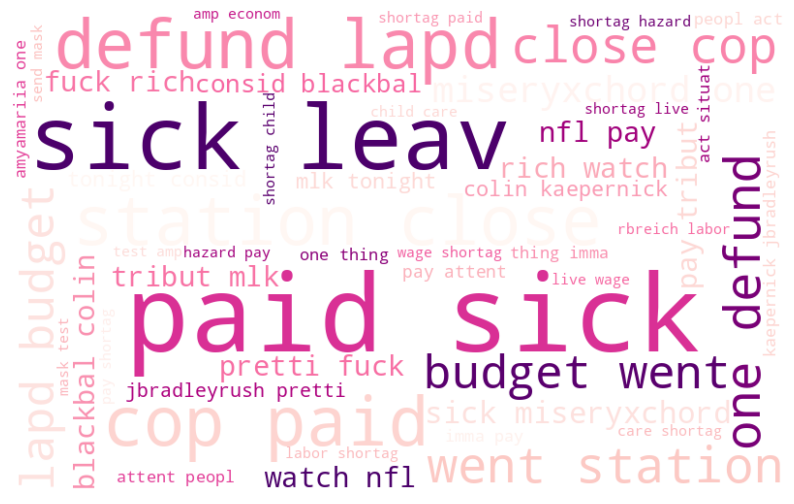

In [ ]:
#display wordcloud for negative words
negative_words = ' '.join([text for text in words_distinct['new_words'][words_distinct['TextBlob_Analysis'] == "Negative"]])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color = 'white', colormap='RdPu', max_font_size=110, max_words = 50).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

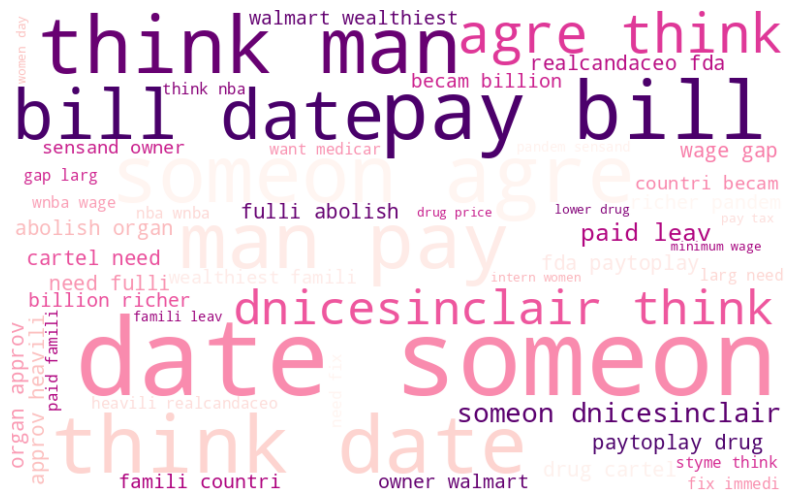

In [ ]:
#display wordcloud for neutral words
neutral_words = ' '.join([text for text in words_distinct['new_words'][words_distinct['TextBlob_Analysis'] == "Neutral"]])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color = 'white', colormap='RdPu', max_font_size=110, max_words = 50).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#Count statistics of positive, negative and neutral tweets
words_distinct.groupby(["TextBlob_Analysis"]).count()

,id,like_count,quote_count,reply_count,retweet_count,words_stemmed,words,new_words,TextBlob_Subjectivity,TextBlob_Polarity
TextBlob_Analysis,,,,,,,,,,
Negative,178838,178838,178838,178838,178838,178838,178838,178838,178838,178838
Neutral,242466,242466,242466,242466,242466,242466,242466,242466,242466,242466
Positive,202251,202251,202251,202251,202251,202251,202251,202251,202251,202251


In [ ]:
#Average statistics of positive, negative and neutral tweets
words_distinct.groupby(["TextBlob_Analysis"]).mean()

<ipython-input-49-eaa7efd5a948>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  words_distinct.groupby(["TextBlob_Analysis"]).mean()


,like_count,quote_count,reply_count,retweet_count,TextBlob_Subjectivity,TextBlob_Polarity
TextBlob_Analysis,,,,,,
Negative,200.665630,7.037693,12.173537,5530.121501,0.607729,-0.313879
Neutral,427.090681,14.440668,44.865482,4316.843207,0.046006,0.000000
Positive,359.271979,11.510603,31.409783,2485.270041,0.486035,0.249802


In [ ]:
#Percentage of Negative Tweets
(178749/(178749+242322+202111))*100

28.683273907141093

In [ ]:
#Percentage of Neutral Tweets
(242322/(178749+242322+202111))*100

38.884627604776774

In [ ]:
#Percentage of Positive Tweets
(202111/(178749+242322+202111))*100

32.43209848808213

In [ ]:
28.683273907141093+38.884627604776774+32.43209848808213

100.0

**Engagement of users with positive and negative tweets**

Defining engagement of tweets on the basis of their like, reply, retweet and quote counts, hypothesis test is conducted for positive and negative tweets

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

In [ ]:
#making two different dataframes for positive and negative tweets
df_positive = words_distinct[words_distinct['TextBlob_Analysis'] == "Positive"]
df_negative = words_distinct[words_distinct['TextBlob_Analysis'] == "Negative"]

In [ ]:
#on the basis of like count
ttest_ind(df_positive['like_count'], df_negative['like_count'], alternative = "greater")

Ttest_indResult(statistic=8.106590560140015, pvalue=2.6106038277750773e-16)

In [ ]:
#on the basis of quote count
ttest_ind(df_positive['quote_count'], df_negative['quote_count'])

Ttest_indResult(statistic=4.915014292581595, pvalue=8.881274587286708e-07)

In [ ]:
#on the basis of reply count
ttest_ind(df_positive['reply_count'], df_negative['reply_count'])

Ttest_indResult(statistic=2.3570803822327955, pvalue=0.018419762123772665)

In [ ]:
#on the basis of retweet count
ttest_ind(df_positive['retweet_count'], df_negative['retweet_count'])

Ttest_indResult(statistic=-123.1793285590628, pvalue=0.0)

**References**

* Flattening json data in pyspark:  https://towardsdatascience.com/flattening-json-records-using-pyspark-b83137669def


* Explode multiple columns in pyspark:  https://dbmstutorials.com/pyspark/spark-dataframe-multiple-explode.html  

* Text Preprocessing: https://spark.apache.org/docs/2.0.2/ml-features.html 

* Hyothesis Testing: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html 

* Public Opinion Mining: https://iopscience.iop.org/article/10.1088/2632-072X/ab8784/pdf 
* Topic Modelling: References in this article has link to interesting topic modeling papers:  https://www.toptal.com/python/topic-modeling-python 

* Exploring Location Data: https://shihaojran.com/geographical-visualization-and-network-analysis-for-twitter-data/ 

